In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [2]:
project_id = 'qwiklabs-gcp-03-c63e9e82159a'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [4]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

# Read the BigQuery table "qwiklabs-gcp-03-c63e9e82159a.ecommerce.customer_stats" into a BigFrames DataFrame.
df = bpd.read_gbq("qwiklabs-gcp-03-c63e9e82159a.ecommerce.customer_stats")

# Select the top 10 records from the DataFrame.
result = df.head(10)

In [5]:
bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head(10)

/usr/local/lib/python3.11/dist-packages/bigframes/core/log_adapter.py:175: UserWarning: Reading cached table from 2025-09-24 09:08:06.642059+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)


,user_id,days_since_last_order,count_orders,average_spend
0,4330,1089,2,63.75
1,76172,1272,3,41.319999
2,82565,1299,2,60.495
3,633,1026,1,78.75
4,51017,1101,1,44.0
5,34424,1022,1,57.990002
6,14766,1048,2,54.994999
7,1748,1087,1,45.990002
8,9631,1138,1,13.59
9,71335,1226,1,176.0


In [6]:
# prompt: 1. Split the DataFrame df into training and testing sets using train_test_split with a test size of 0.2 and random_state=42 for reproducibility. Store the splits as df_train and df_test. 2. Create a KMeans clustering model using bigframes.ml.cluster.KMeans with 5 clusters (note: do not include random_state since it's unsupported). 3. Fit the KMeans model on the training data (df_train). 4. Save the trained model to BigQuery using the to_gbq method, specifying the model path as project_id.dataset_name.model_name. 5. Store the trained model object in a variable named result.

# Split the DataFrame df into training and testing sets.
# We use train_test_split from bigframes.ml.model_selection, specifying the test size and a random state for reproducibility.
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Create a KMeans clustering model with 5 clusters.
# We instantiate KMeans from bigframes.ml.cluster.
kmeans_model = KMeans(n_clusters=5)

# Fit the KMeans model on the training data.
# The fit method trains the model using the provided DataFrame.
kmeans_model.fit(df_train)

# Save the trained model to BigQuery.
# The to_gbq method saves the model to the specified BigQuery path.
kmeans_model.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

# Store the trained model object in the 'result' variable.
result = kmeans_model

In [7]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

import pandas_gbq
predictions_df = kmeans_model.predict(df)
result = predictions_df.head(10)

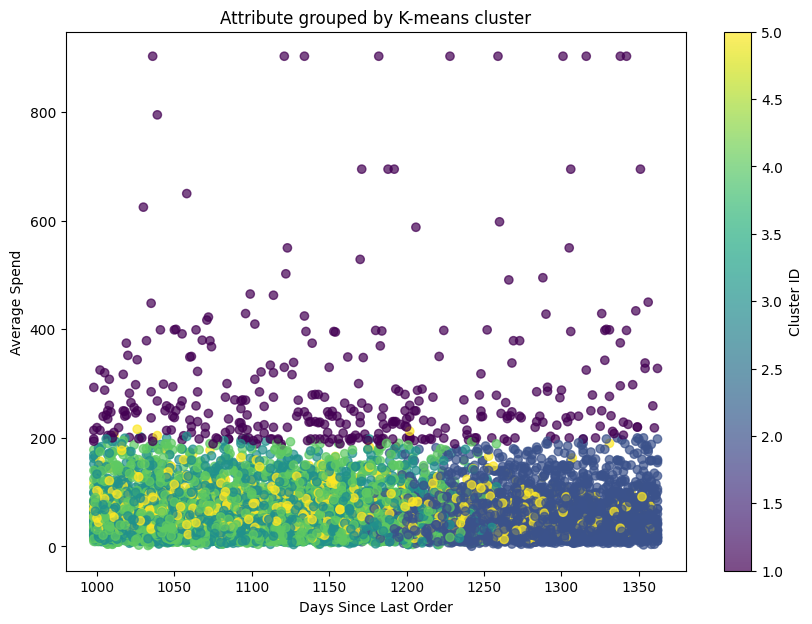

In [8]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt

# Create the scatterplot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    predictions_df["days_since_last_order"],
    predictions_df["average_spend"],
    c=predictions_df["CENTROID_ID"],
    cmap="viridis",
    alpha=0.7,
)

# Add labels and title
plt.xlabel("Days Since Last Order")
plt.ylabel("Average Spend")
plt.title("Attribute grouped by K-means cluster")

# Add a color bar
plt.colorbar(scatter, label="Cluster ID")

# Show the plot
plt.show()

In [9]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,318.16,1.12,1164.65
1,cluster 2,51.87,1.26,1283.15
2,cluster 3,53.65,1.40,1097.91
3,cluster 4,53.73,1.26,1101.22
4,cluster 5,60.24,3.75,1140.67


In [10]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $318.16, count of orders per person 1.12, days since last order 1164.65
cluster 2, average spend $51.87, count of orders per person 1.26, days since last order 1283.15
cluster 3, average spend $53.65, count of orders per person 1.4, days since last order 1097.91
cluster 4, average spend $53.73, count of orders per person 1.26, days since last order 1101.22
cluster 5, average spend $60.24, count of orders per person 3.75, days since last order 1140.67


In [11]:
model = GenerativeModel("gemini-2.5-pro")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 4000,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

/usr/local/lib/python3.11/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Of course. As a creative brand strategist, my goal is to transform raw data into human stories and actionable strategies. The most critical insight from this data is that **all clusters represent lapsed customers** (last order was ~3 years ago). Therefore, our entire strategy must be focused on **reactivation and winning them back**, but tailored to their past behavior.

Here is the strategic breakdown for each cluster.

---

### **Cluster 1**

*   **Data:** Average spend $318.16, count of orders 1.12, days since last order 1164.65

*   **Title:** **The One-Time High Roller**

*   **Persona:** Meet Eleanor, 55. Three years ago, she was likely making a significant, considered purchase. This wasn't an impulse buy; it was an investment. Perhaps she bought a full set of premium cookware for her newly renovated kitchen, a designer leather bag for a milestone birthday, or a high-end piece of furniture. She values quality, is willing to pay for it, but isn't a frequent browser. She made her b